<a href="https://colab.research.google.com/github/yetinam/pyocto/blob/examples/02_velocity_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![image](https://raw.githubusercontent.com/yetinam/pyocto/main/docs/_static/pyocto_logo_outlined.svg)

*This code is necessary on colab to install PyOcto. If PyOcto is already installed on your machine, you can skip this. In addition, we install PyArrow and Pyrocko. PyArrow is required for reading our example data in parquet format. PyRocko for creating the 1D velocity models.*

In [ ]:
!pip install pyocto pyarrow pyrocko

# Velocity models

This tutorial introduces the PyOcto velocity models. PyOcto supports homogeneous models and 1D layered velocity models. For this tutorial, we assume familiarity with the basics of PyOcto. Take a look at the basics tutorial if you haven't done so yet.

In [1]:
import pyocto
import pandas as pd
import datetime
import matplotlib.pyplot as plt

For this notebook, we use the same example data as for the basics notebook, i.e., synthetic events in Chile.

In [ ]:
!wget https://github.com/yetinam/pyocto/raw/main/tests/data/picks
!wget https://github.com/yetinam/pyocto/raw/main/tests/data/stations
!wget https://github.com/yetinam/pyocto/raw/main/tests/data/graeber.csv

In [2]:
picks = pd.read_parquet("picks")
picks["time"] = picks["time"].apply(lambda x: x.timestamp())
stations = pd.read_parquet("stations")

## Homogeneous velocity models

In the basics tutorial, we already introduced the homogeneous velocity model. It assumes a constant P and S velocity everywhere in the medium. This assumption is usually sufficient for shallow seismicity and even for subduction zones leads to good results. Let's create a velocity model.

In [3]:
velocity_model = pyocto.VelocityModel0D(
    p_velocity=7.0,
    s_velocity=4.0,
    tolerance=2.0,
)

With the velocity model, we create an associator instance and run the association. This will take a few seconds.

In [4]:
associator = pyocto.OctoAssociator.from_area(
    lat=(-25, -18),
    lon=(-71.5, -68),
    zlim=(0, 200),
    time_before=300,
    velocity_model=velocity_model,
    n_picks=10,
    n_p_and_s_picks=4,
)
associator.transform_stations(stations)
events_0d, assignments_0d = associator.associate(picks, stations)

## 1D velocity models

Using a 1D velocity model consists of two steps. First, we need to prepare the model. Second, we create an instance of the model to pass to PyOcto. Let's start by loading our velocity model from a csv file.

In [5]:
layers = pd.read_csv("graeber.csv")
layers

,depth,vp,vp_grad,vs,vs_grad,x,y
0,0.0,6.1,0.00,3.6,0.00,1.0,0.0
1,10.0,6.1,0.03,3.6,0.02,1.0,0.0
2,20.0,6.4,0.01,3.8,0.01,1.0,0.0
3,30.0,6.5,0.06,3.8,0.04,1.0,0.0
4,40.0,7.1,0.00,4.2,0.00,1.0,0.0
5,50.0,7.1,0.02,4.2,0.01,1.0,0.0
6,60.0,7.3,0.06,4.3,0.04,1.0,0.0
7,70.0,7.9,0.02,4.7,0.01,1.0,0.0
8,80.0,8.1,0.04,4.8,0.02,1.0,0.0
9,90.0,8.5,0.00,5.1,0.00,1.0,0.0


For creating a velocity model, we need a data frame with three columns (and all other columns will be ignored): depth, vp, vs. The depth describes the depth in kilometers and vp and vs the P and S wave velocity at these depth. Velocities are interpolated linearly between the provided depth levels.

To prepare the velocity model, we use the `create_model` function. This function will create a travel time grid and save it in a binary format. It takes five arguments:
- The velocity model in the data frame
- The spacing between grid nodes in km
- The horizontal extent of the grid
- The vertical extent of the grid
- The path to write the final model to
The velocity grid will always be anchored at depth 0 and distance 0.

In [6]:
model_path = "velocity_model"
pyocto.VelocityModel1D.create_model(layers, 1., 400, 250, model_path)

To load the model, we use a similar call as for the homogeneous model. However, instead of passing p and s velocities, we now pass the model path. Note that this means that we can reuse a model that we created once multiple times.

In [7]:
velocity_model = pyocto.VelocityModel1D(model_path, tolerance=2.0)

In [8]:
associator = pyocto.OctoAssociator.from_area(
    lat=(-25, -18),
    lon=(-71.5, -68),
    zlim=(0, 200),
    time_before=300,
    velocity_model=velocity_model,
    n_picks=10,
    n_p_and_s_picks=4,
)
associator.transform_stations(stations)
events_1d, assignments_1d = associator.associate(picks, stations)

Let's compare the outputs of the two models. In this case, both models found the same number of events (often the 1D model finds more). However, the 1D model was able to associate substantially more picks to these events.

In [9]:
print("0D model - Events: ", len(events_0d), "Picks: ", events_0d["picks"].sum())
print("1D model - Events: ", len(events_1d), "Picks: ", events_1d["picks"].sum())

0D model - Events:  48 Picks:  864
1D model - Events:  48 Picks:  1069


Let's compare the detected event catalogs visually. The two catalogs show both systematic and stoachstic differences. The homogeneous model consistently overestimates depth of the deeper events as the assumed phase velocities here are too low. In addition, the model shows more scatter as the locations are not as focussed.

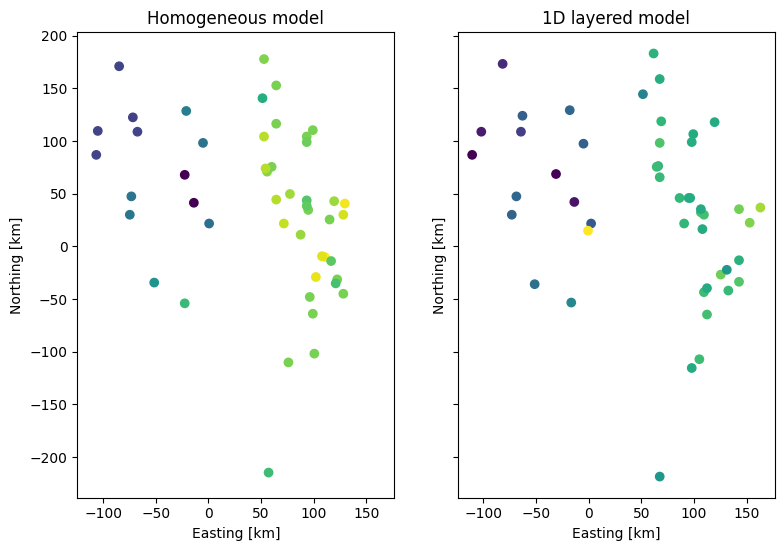

In [10]:
fig = plt.figure(figsize=(9, 8))
axs = fig.subplots(1, 2, sharex=True, sharey=True)

for ax in axs:
    ax.set_aspect("equal")
    ax.set_xlabel("Easting [km]")
    ax.set_ylabel("Northing [km]")

axs[0].set_title("Homogeneous model")
axs[1].set_title("1D layered model")
axs[0].scatter(events_0d["x"], events_0d["y"], c=events_0d["z"])
axs[1].scatter(events_1d["x"], events_1d["y"], c=events_1d["z"])

## Additional configuration options

Velocity models offer additional configuration options. We already used the `tolerance` parameter. This parameter describes by how much an observed and a predicted travel time are allowed to differ. This accounts for inaccuracies in the velocity model and the pick times. In general, a lower tolerance will lead to fewer detected events, a higher tolerance to more events. However, a too high tolerance will lead to too many false detections. In addition, higher tolerance values lead to longer run times.

On important option for large deployments is the `association_cutoff_distance`. For large deployments, it is often sufficient to only search among stations up to a certain distance, if their picks could be associated. Afterwards, picks at further away stations can be added in the localisation and pick matching stage. This safes substantial runtime. Let's try this out with a 1D velocity model.

In [11]:
velocity_model = pyocto.VelocityModel1D(model_path, tolerance=2.0, association_cutoff_distance=250)
associator = pyocto.OctoAssociator.from_area(
    lat=(-25, -18),
    lon=(-71.5, -68),
    zlim=(0, 200),
    time_before=300,
    velocity_model=velocity_model,
    n_picks=10,
    n_p_and_s_picks=4,
)
associator.transform_stations(stations)
events, assignments = associator.associate(picks, stations)

Comparing the outputs, we found the same number of events, even though we lost 10 picks through the cutoff. If these picks were actual picks or false associations is unclear.

In [12]:
print("1D model (250 km cutoff) - Events: ", len(events), "Picks: ", events["picks"].sum())
print("1D model - Events: ", len(events_1d), "Picks: ", events_1d["picks"].sum())

1D model (250 km cutoff) - Events:  48 Picks:  1059
1D model - Events:  48 Picks:  1069


If you want to know more details on velocity models and their parameters, check out the [documentation page](https://pyocto.readthedocs.io/en/latest/pages/velocity_models.html).